In [1]:
# Auto-prepare data if missing, robustly locate project root and run data loader
import sys
import subprocess
from pathlib import Path

def find_project_root(start: Path = None) -> Path:
    """Search upward from start (or cwd) for a directory containing 'src' folder.
    Returns the Path if found, otherwise returns cwd."""
    if start is None:
        start = Path.cwd()
    cur = start.resolve()
    root = Path(cur.root)
    while True:
        if (cur / 'src').is_dir():
            return cur
        if cur == root:
            return start
        cur = cur.parent

PROJECT_ROOT = find_project_root()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

DATA_DIR = PROJECT_ROOT / 'data'
train_path = DATA_DIR / 'train.csv'
test_path = DATA_DIR / 'test.csv'

def prepare_data_via_import(json_path: Path):
    # Try to import the loader module and call prepare_datasets
    import importlib
    try:
        dl = importlib.import_module('src.data_loader')
        dl.prepare_datasets(str(json_path))
        return True, None
    except Exception as e:
        return False, e

def prepare_data_via_subprocess(json_path: Path):
    # Fallback: run the loader as a module in a subprocess
    cmd = [sys.executable, '-m', 'src.data_loader', str(json_path)]
    try:
        subprocess.check_call(cmd)
        return True, None
    except subprocess.CalledProcessError as e:
        return False, e

if not train_path.exists() or not test_path.exists():
    print('data/train.csv or data/test.csv not found. Attempting to create them...')
    json_path = DATA_DIR / 'public_cases.json'
    if not json_path.exists():
        raise FileNotFoundError(f'Expected JSON not found at {json_path}. Please place public_cases.json in data/')

    ok, err = prepare_data_via_import(json_path)
    if not ok:
        print('Import approach failed, trying subprocess approach...')
        ok2, err2 = prepare_data_via_subprocess(json_path)
        if not ok2:
            # Provide helpful error including both exceptions
            raise FileNotFoundError(
                'Could not prepare data/train.csv and data/test.csv automatically. ' 
                f'Import error: {err}; Subprocess error: {err2}.\nRun `python -m src.data_loader data/public_cases.json` from the project root.'
            )
    print('Data preparation completed.')

# Now load the CSVs for EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
df = pd.concat([train.assign(split='train'), test.assign(split='test')], ignore_index=True)
df.head()

,trip_duration_days,miles_traveled,total_receipts_amount,reimbursement_amount,split
0,10,1192,23.47,1157.87,train
1,12,296,326.83,981.72,train
2,10,532,1223.36,1631.49,train
3,4,1065,119.34,781.82,train
4,2,933,1589.58,1489.99,train


# 01_EDA — Exploratory Data Analysis

This notebook performs statistical summaries, distribution plots, correlation analysis, outlier detection, and a preview of derived features.

In [2]:
display(df[['trip_duration_days','miles_traveled','total_receipts_amount','reimbursement_amount']].describe().T)

,count,mean,std,min,25%,50%,75%,max
trip_duration_days,1000.0,7.04300,3.926139,1.00,4.0000,7.00,10.0000,14.00
miles_traveled,1000.0,597.39500,351.312951,5.00,275.7500,621.00,893.0000,1317.00
total_receipts_amount,1000.0,1211.05687,742.854180,1.42,530.3775,1171.90,1881.1050,2503.46
reimbursement_amount,1000.0,1349.11403,470.316464,117.24,1019.2975,1454.26,1711.1225,2337.73


## Distribution analysis

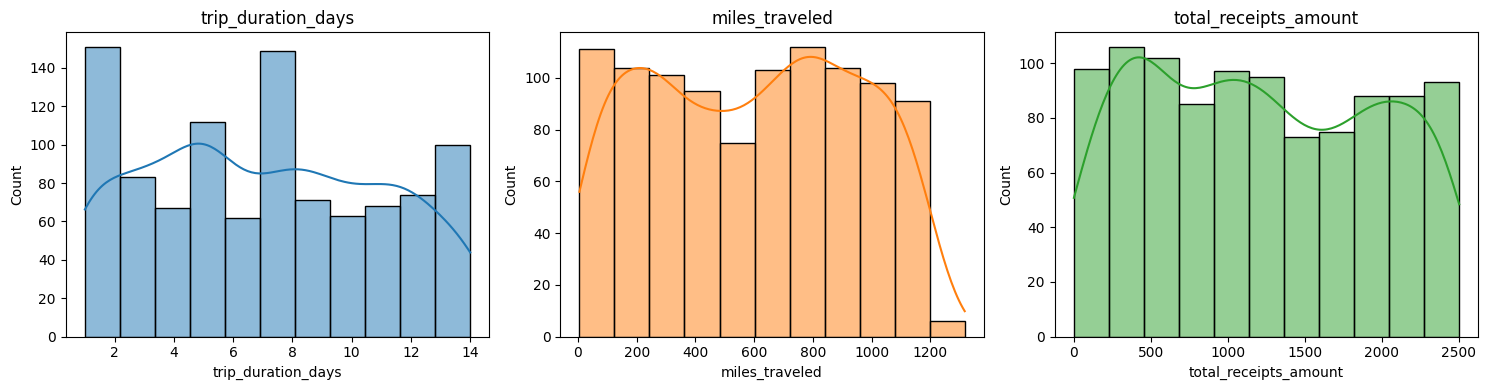

In [3]:
fig, axes = plt.subplots(1,3, figsize=(15,4))
sns.histplot(df['trip_duration_days'], ax=axes[0], kde=True, color='C0')
axes[0].set_title('trip_duration_days')
sns.histplot(df['miles_traveled'], ax=axes[1], kde=True, color='C1')
axes[1].set_title('miles_traveled')
sns.histplot(df['total_receipts_amount'], ax=axes[2], kde=True, color='C2')
axes[2].set_title('total_receipts_amount')
plt.tight_layout()
plt.show()

## Correlation analysis

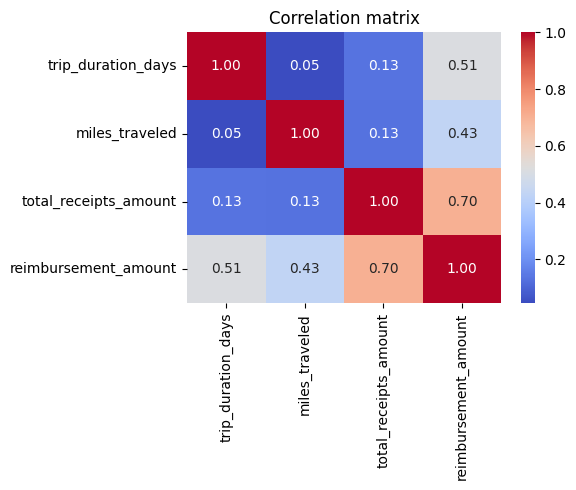

In [4]:
corr = df[['trip_duration_days','miles_traveled','total_receipts_amount','reimbursement_amount']].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation matrix')
plt.tight_layout()
plt.show()

## Outlier detection and missing data

Missing values per column:
trip_duration_days       0
miles_traveled           0
total_receipts_amount    0
reimbursement_amount     0
split                    0
dtype: int64


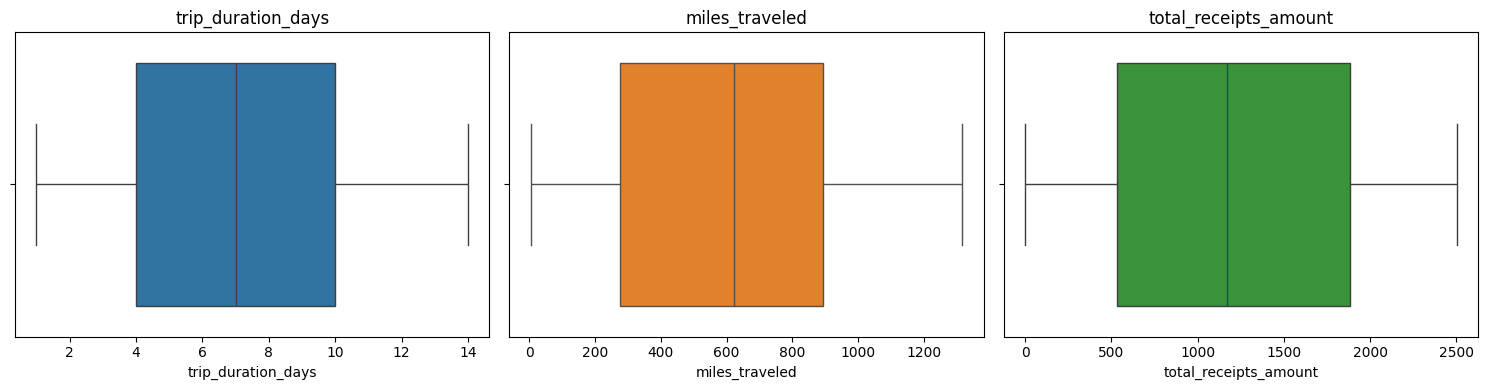

In [5]:
print('Missing values per column:')
print(df.isna().sum())

fig, axes = plt.subplots(1,3, figsize=(15,4))
sns.boxplot(x=df['trip_duration_days'], ax=axes[0], color='C0')
axes[0].set_title('trip_duration_days')
sns.boxplot(x=df['miles_traveled'], ax=axes[1], color='C1')
axes[1].set_title('miles_traveled')
sns.boxplot(x=df['total_receipts_amount'], ax=axes[2], color='C2')
axes[2].set_title('total_receipts_amount')
plt.tight_layout()
plt.show()

## Derived features preview (cost per mile/day)

,count,mean,std,min,25%,50%,75%,max
cost_per_mile,1000.0,6.052378,21.148133,0.015269,0.980573,1.952640,3.703540,296.514286
cost_per_day,1000.0,285.706081,381.707793,0.473333,85.845821,169.089176,300.643071,2452.850000


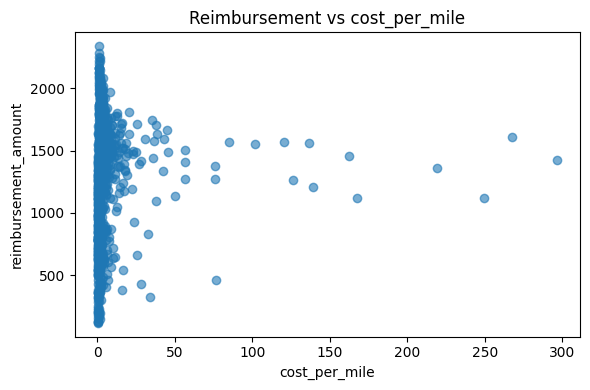

In [6]:
df2 = df.copy()
df2['cost_per_mile'] = df2['total_receipts_amount'] / df2['miles_traveled'].replace(0, np.nan)
df2['cost_per_mile'] = df2['cost_per_mile'].fillna(0)
df2['cost_per_day'] = df2['total_receipts_amount'] / df2['trip_duration_days'].replace(0, np.nan)
df2['cost_per_day'] = df2['cost_per_day'].fillna(0)
display(df2[['cost_per_mile','cost_per_day']].describe().T)
plt.figure(figsize=(6,4))
plt.scatter(df2['cost_per_mile'], df2['reimbursement_amount'], alpha=0.6)
plt.xlabel('cost_per_mile')
plt.ylabel('reimbursement_amount')
plt.title('Reimbursement vs cost_per_mile')
plt.tight_layout()
plt.show()